In [4]:
import rasterio
from rasterio.windows import Window
import torch
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
from matplotlib import colors

In [15]:
def load_window(year, window_size=5100, offset=[0,0], data_type="landuse", dataset="train"):
    suffix = "_test" if dataset == "test" else ""
    path = f"../data/processed/{30}m/{data_type}/"  + f"{data_type}_{year}{suffix}.tif"
    # Open the mosaic file
    with rasterio.open(path) as src:
        fill_value = 255 if data_type == "landuse" else 0
        window = rasterio.windows.Window(offset[0], offset[1], window_size, window_size)
        data = src.read(window=window, fill_value=fill_value, boundless=True)
        data = data.squeeze()
        data = data.astype(bool) if data_type == "aggregated" else data.astype(np.uint8)
    return torch.from_numpy(data)


In [16]:
train_data = torch.load("../data/processed/30m/train_data.pt")
val_data = torch.load("../data/processed/30m/val_data.pt")

In [48]:
delta = 55
window_size = delta * 500

with rasterio.open(f"../data/processed/{30}m/deforestation/" + f"deforestation_2010.tif") as src:
    height = src.height
    width = src.width

train_features = []
val_features = []

for window_x in range(0, int(width/window_size)+1):
    for window_y in range(0, int(height/window_size)+1):
        offset = [window_x*window_size, window_y*window_size]
        print(f"Loading window {window_x}, {window_y} with offset {offset}")
        features = []
        past_horizons = [1, 5, 10]
        for i in past_horizons:
            features.append(load_window(i, window_size=window_size, offset=offset, data_type="aggregated"))
        features.append(load_window(2009, window_size=window_size, offset=offset, data_type="deforestation"))
        features.append(load_window(2010, window_size=window_size, offset=offset, data_type="deforestation"))
        features = torch.stack(features)

        features = features.unfold(1, delta, delta).unfold(2, delta, delta)
        features = features.moveaxis(0,2)

        '''
        train_indices = train_data[(train_data[:,0] < (offset[0]+window_size)) 
                             & (train_data[:,1] < (offset[1]+window_size)) 
                             & (train_data[:,0] > (offset[0]))
                             & (train_data[:,1] > (offset[1]))]
    
        if len(train_indices) > 0:
            train_indices = ((train_indices[:,:2] - torch.tensor(offset)) / delta).type(torch.int)
            train_features.append(features[train_indices[:,1], train_indices[:,0], :, :, :])
        '''

        val_indices = val_data[(val_data[:,0] < (offset[0]+window_size))
                                & (val_data[:,1] < (offset[1]+window_size))
                                & (val_data[:,0] > (offset[0]))
                                & (val_data[:,1] > (offset[1]))]
        
        if len(val_indices) > 0:
            val_indices = ((val_indices[:,:2] - torch.tensor(offset)) / delta).type(torch.int)
            val_features.append(features[val_indices[:,1], val_indices[:,0], :, :, :])

# train_features = torch.cat(train_features, dim=0)
val_features = torch.cat(val_features, dim=0)

# torch.save(train_features, "../data/processed/30m/train_features.pt")
torch.save(val_features, "../data/processed/30m/val_features.pt")

Loading window 0, 0 with offset [0, 0]
Loading window 0, 1 with offset [0, 27500]
Loading window 0, 2 with offset [0, 55000]
Loading window 0, 3 with offset [0, 82500]
Loading window 1, 0 with offset [27500, 0]
Loading window 1, 1 with offset [27500, 27500]
Loading window 1, 2 with offset [27500, 55000]
Loading window 1, 3 with offset [27500, 82500]
Loading window 2, 0 with offset [55000, 0]
Loading window 2, 1 with offset [55000, 27500]
Loading window 2, 2 with offset [55000, 55000]
Loading window 2, 3 with offset [55000, 82500]
Loading window 3, 0 with offset [82500, 0]
Loading window 3, 1 with offset [82500, 27500]
Loading window 3, 2 with offset [82500, 55000]
Loading window 3, 3 with offset [82500, 82500]


In [47]:
print(train_data.shape)
print(train_features.shape)

torch.Size([209437, 3])
torch.Size([209437, 5, 55, 55])


In [49]:
print(val_data.shape)
print(val_features.shape)

torch.Size([52360, 3])
torch.Size([52360, 5, 55, 55])


# look at datasets

In [2]:
train_features = torch.load("../data/processed/30m/train_features.pt")
val_features = torch.load("../data/processed/30m/val_features.pt")

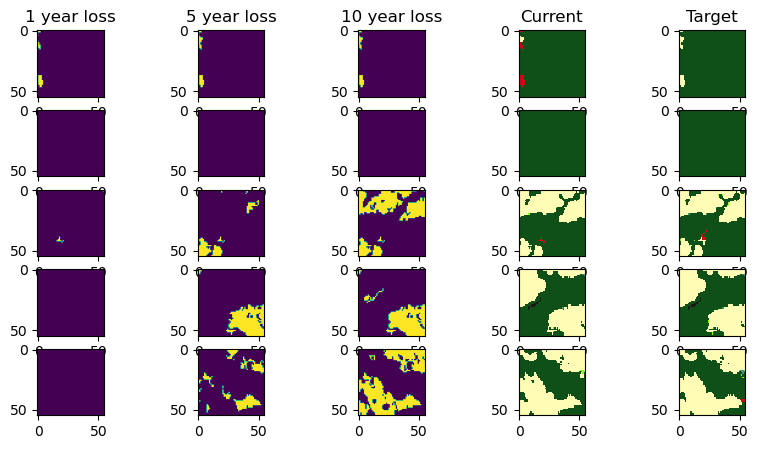

In [10]:
indices = np.random.randint(0, len(train_features), size=5)

cmap = colors.ListedColormap(['#D5D5E5', '#FFFCB5','#0F5018', '#409562', '#D90016', '#87FF0A', '#FD9407', '#191919'])

fig, axs = plt.subplots(len(indices), 5, figsize=(10, 5))

for i, idx in enumerate(indices):
    axs[i,0].imshow(train_features[idx,0,:,:])
    axs[i,1].imshow(train_features[idx,1,:,:])
    axs[i,2].imshow(train_features[idx,2,:,:])
    axs[i,3].imshow(train_features[idx,3,:,:], cmap=cmap,vmin = -.5, vmax = 7.5, interpolation='nearest')
    axs[i,4].imshow(train_features[idx,4,:,:], cmap=cmap,vmin = -.5, vmax = 7.5, interpolation='nearest')

    axs[0,0].title.set_text(f'1 year loss')
    axs[0,1].title.set_text(f'5 year loss')
    axs[0,2].title.set_text(f'10 year loss')
    axs[0,3].title.set_text(f'Current')
    axs[0,4].title.set_text(f'Target')
plt.show()
